In [33]:
# Imports
from pyulog import ULog
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# interesting message names
ulog = ULog("log_198_2025-3-27-17-30-46.ulg")
msg_names = [msg.name for msg in ulog.data_list]
print("Message Names:", msg_names)

Message Names: ['action_request', 'actuator_armed', 'actuator_motors', 'actuator_outputs', 'actuator_outputs', 'battery_status', 'config_overrides', 'control_allocator_status', 'cpuload', 'ekf2_timestamps', 'estimator_attitude', 'estimator_attitude', 'estimator_attitude', 'estimator_baro_bias', 'estimator_baro_bias', 'estimator_baro_bias', 'estimator_event_flags', 'estimator_event_flags', 'estimator_event_flags', 'estimator_global_position', 'estimator_global_position', 'estimator_global_position', 'estimator_gps_status', 'estimator_gps_status', 'estimator_gps_status', 'estimator_innovation_test_ratios', 'estimator_innovation_test_ratios', 'estimator_innovation_test_ratios', 'estimator_innovation_variances', 'estimator_innovation_variances', 'estimator_innovation_variances', 'estimator_innovations', 'estimator_innovations', 'estimator_innovations', 'estimator_local_position', 'estimator_local_position', 'estimator_local_position', 'estimator_selector_status', 'estimator_sensor_bias', '

Let's first find the consecutive periods of activated offboard mode.

In [35]:
consecutive_timestamps = {}
cons_idx = 0
for msg in ulog.data_list:
    if msg.name == "vehicle_control_mode":
        flag_values = msg.data.get("flag_control_offboard_enabled")
        timestamps = msg.data.get("timestamp")
        
        for idx, (flag, ts) in enumerate(list(zip(flag_values, timestamps))):
            if idx == 0:
                continue
            
            prev_ts = timestamps[idx - 1]
            if flag_values[idx - 1] == 1:
                if flag == 1:
                    consecutive_timestamps.setdefault(cons_idx, []).append(prev_ts)
                elif flag == 0:
                    consecutive_timestamps.setdefault(cons_idx, []).append(prev_ts)
                    cons_idx += 1

print("How many consecutive periods:")
print(len(list(consecutive_timestamps)))#

How many consecutive periods:
2


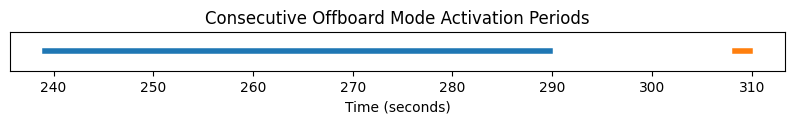

In [36]:
fig, ax = plt.subplots(figsize=(10, 0.5)) 
y_level = 1

for period, timestamps in consecutive_timestamps.items():
    start_time = min(timestamps) / 1e6  # Convert from microseconds to seconds
    end_time = max(timestamps) / 1e6    # Convert from microseconds to seconds
    ax.plot([start_time, end_time], [y_level, y_level], label=f"Period {period+1}", linewidth=4)

ax.set_xlabel("Time (seconds)")
ax.set_yticks([])
ax.set_title("Consecutive Offboard Mode Activation Periods")
plt.show()

Next, let's plot the velocities and local positions of the vehicle during this longer period.

Offboard flight lasted 51 seconds


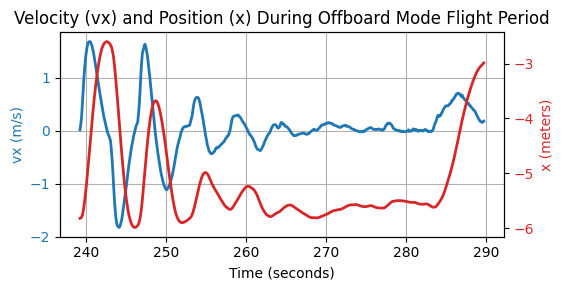

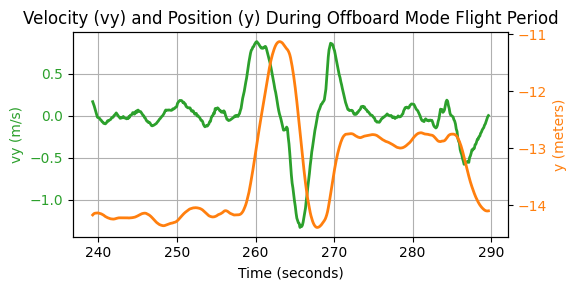

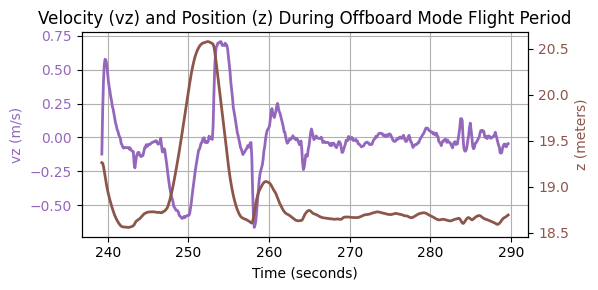

In [37]:
import numpy as np
import matplotlib.pyplot as plt


start_time = min(consecutive_timestamps[0])
end_time = max(consecutive_timestamps[0]) 
print("Offboard flight lasted", round((end_time - start_time) / 1e6), "seconds")


start_time = start_time / 1e6
end_time = end_time / 1e6    

vx_values = []
vy_values = []
vz_values = []
x_values = []
y_values = []
z_values = []
timestamps = []


for msg in ulog.data_list:
    if msg.name == "vehicle_local_position":
        msg_timestamps = msg.data["timestamp"] / 1e6  
        msg_velocities = msg.data["vx"], msg.data["vy"], msg.data["vz"]
        msg_positions = msg.data["x"], msg.data["y"], msg.data["z"] 

        for ts, vx, vy, vz, x, y, z in zip(msg_timestamps, *msg_velocities, *msg_positions):
            if start_time <= ts <= end_time:
                vx_values.append(vx)
                vy_values.append(vy)
                vz_values.append(vz)
                x_values.append(x)
                y_values.append(y)
                z_values.append(-z)
                timestamps.append(ts)

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.plot(timestamps, vx_values, label="vx (m/s)", color='tab:blue', linewidth=2)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("vx (m/s)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(timestamps, x_values, label="x (meters)", color='tab:red', linewidth=2)
ax2.set_ylabel("x (meters)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(True)
plt.title("Velocity (vx) and Position (x) During Offboard Mode Flight Period")
fig.tight_layout()


fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.plot(timestamps, vy_values, label="vy (m/s)", color='tab:green', linewidth=2)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("vy (m/s)", color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
ax2.plot(timestamps, y_values, label="y (meters)", color='tab:orange', linewidth=2)
ax2.set_ylabel("y (meters)", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.grid(True)
plt.title("Velocity (vy) and Position (y) During Offboard Mode Flight Period")
fig.tight_layout()


fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.plot(timestamps, vz_values, label="vz (m/s)", color='tab:purple', linewidth=2)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("vz (m/s)", color='tab:purple')
ax1.tick_params(axis='y', labelcolor='tab:purple')

ax2 = ax1.twinx()
ax2.plot(timestamps, z_values, label="z (meters)", color='tab:brown', linewidth=2)
ax2.set_ylabel("z (meters)", color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')

ax1.grid(True)
plt.title("Velocity (vz) and Position (z) During Offboard Mode Flight Period")
fig.tight_layout()


plt.show()


Let's check the rotation speed during this period, with the same chart as regular velocity.

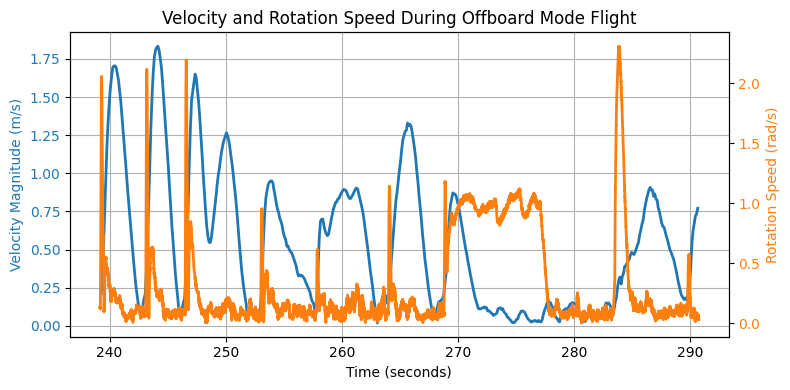

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists
velocity_magnitude = []
rotation_speed_magnitude = []
timestamps = []

# Extract velocity magnitude
for msg in ulog.data_list:
    if msg.name == "vehicle_local_position":
        msg_timestamps = msg.data["timestamp"] / 1e6  
        vx, vy, vz = msg.data["vx"], msg.data["vy"], msg.data["vz"]

        for ts, v_x, v_y, v_z in zip(msg_timestamps, vx, vy, vz):
            if start_time <= ts <= end_time + 1.0:
                velocity_magnitude.append(np.linalg.norm([v_x, v_y, v_z]))
                timestamps.append(ts)

rot_timestamps = []
for msg in ulog.data_list:
    if msg.name == "vehicle_angular_velocity":
        msg_timestamps = msg.data["timestamp"] / 1e6  
        rollspeed, pitchspeed, yawspeed = msg.data["xyz[0]"], msg.data["xyz[1]"], msg.data["xyz[2]"]

        for ts, rs, ps, ys in zip(msg_timestamps, rollspeed, pitchspeed, yawspeed):
            if start_time <= ts <= end_time + 1.0:
                rotation_speed_magnitude.append(np.linalg.norm([rs, ps, ys]))
                rot_timestamps.append(ts)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(timestamps, velocity_magnitude, label="Velocity Magnitude (m/s)", color='tab:blue', linewidth=2)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Velocity Magnitude (m/s)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(rot_timestamps, rotation_speed_magnitude, label="Rotation Speed Magnitude (rad/s)", color='tab:orange', linewidth=2)
ax2.set_ylabel("Rotation Speed (rad/s)", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
plt.title("Velocity and Rotation Speed During Offboard Mode Flight")
fig.tight_layout()
plt.show()


In [48]:
off_ts = 290

for msg in ulog.data_list:
    if msg.name == "failsafe_flags":
        timestamps = msg.data["timestamp"] / 1e6
        flag_names = [key for key in msg.data.keys() if key != "timestamp"]
        for i, ts in enumerate(timestamps):
            if any(msg.data[flag][i] for flag in flag_names):  # If any flag is true
                if abs(ts - end_time) < 0.5:  # Within 0.5s window
                    print(f"\nPossible failsafe trigger at {ts:.3f}s:")
                    for flag in flag_names:
                        if msg.data[flag][i]:
                            print(f" - {flag} activated")



Possible failsafe trigger at 289.641s:
 - mode_req_angular_velocity activated
 - mode_req_attitude activated
 - mode_req_local_alt activated
 - mode_req_local_position activated
 - mode_req_local_position_relaxed activated
 - mode_req_global_position activated
 - mode_req_mission activated
 - mode_req_offboard_signal activated
 - mode_req_home_position activated
 - mode_req_wind_and_flight_time_compliance activated
 - mode_req_prevent_arming activated
 - mode_req_manual_control activated
 - mode_req_other activated

Possible failsafe trigger at 289.751s:
 - mode_req_angular_velocity activated
 - mode_req_attitude activated
 - mode_req_local_alt activated
 - mode_req_local_position activated
 - mode_req_local_position_relaxed activated
 - mode_req_global_position activated
 - mode_req_mission activated
 - mode_req_offboard_signal activated
 - mode_req_home_position activated
 - mode_req_wind_and_flight_time_compliance activated
 - mode_req_prevent_arming activated
 - mode_req_manual_co

We can see from the previous print that the following flags were activated in the last moments of offboard mode:
- local_position_invalid activated
- local_position_invalid_relaxed activated
- local_velocity_invalid activated
- global_position_invalid activated
- offboard_control_signal_lost activated

The question is, why? Let's plot some positions and velocities to understand what happened.

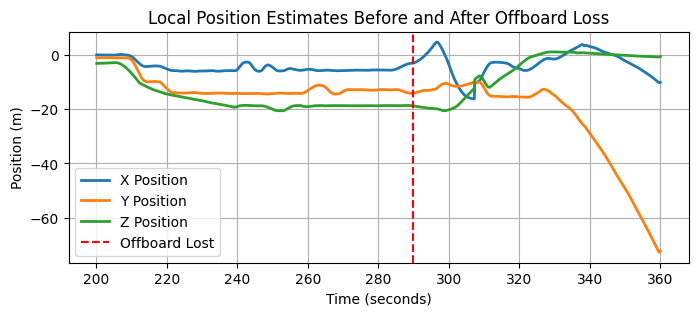

In [40]:
timestamps = []
x_positions = []
y_positions = []
z_positions = []

for msg in ulog.data_list:
    if msg.name == "vehicle_local_position":
        ts = msg.data["timestamp"] / 1e6 
        x, y, z = msg.data["x"], msg.data["y"], msg.data["z"]
        
        timestamps.extend(ts)
        x_positions.extend(x)
        y_positions.extend(y)
        z_positions.extend(z)

plt.figure(figsize=(8, 3))
plt.plot(timestamps, x_positions, label="X Position", linewidth=2)
plt.plot(timestamps, y_positions, label="Y Position", linewidth=2)
plt.plot(timestamps, z_positions, label="Z Position", linewidth=2)
plt.axvline(x=end_time, color='r', linestyle='--', label="Offboard Lost")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Local Position Estimates Before and After Offboard Loss")
plt.grid(True)
plt.show()

1518 1518 1518 1518


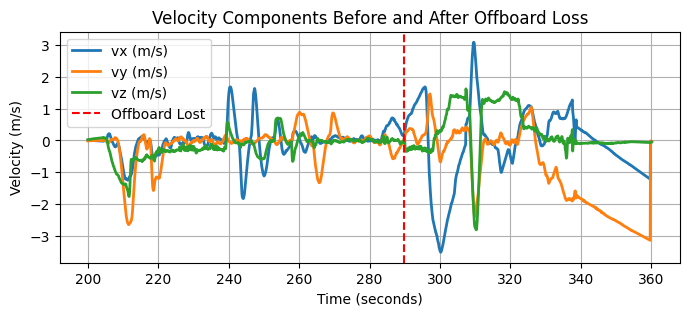

In [41]:
# Initialize lists for velocities and timestamps
timestamps = []
vx_values = []
vy_values = []
vz_values = []

# Extract velocity data from the ulog and corresponding timestamps
for msg in ulog.data_list:
    if msg.name == "vehicle_local_position":
        ts = msg.data["timestamp"] / 1e6  # Convert to seconds
        vx, vy, vz = msg.data["vx"], msg.data["vy"], msg.data["vz"]  # Velocity components
        
        # Append only corresponding timestamps and velocities
        timestamps.extend(ts)  # Ensure timestamps are aligned with the velocities
        vx_values.extend(vx)
        vy_values.extend(vy)
        vz_values.extend(vz)

# Ensure lengths match for the plot
print(len(timestamps), len(vx_values), len(vy_values), len(vz_values))

# Plot the velocities with timestamps
plt.figure(figsize=(8, 3))
plt.plot(timestamps, vx_values, label="vx (m/s)", linewidth=2)
plt.plot(timestamps, vy_values, label="vy (m/s)", linewidth=2)
plt.plot(timestamps, vz_values, label="vz (m/s)", linewidth=2)

# Mark the offboard loss time
plt.axvline(x=end_time, color='r', linestyle='--', label="Offboard Lost")
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Velocity Components Before and After Offboard Loss")
plt.grid(True)
plt.show()


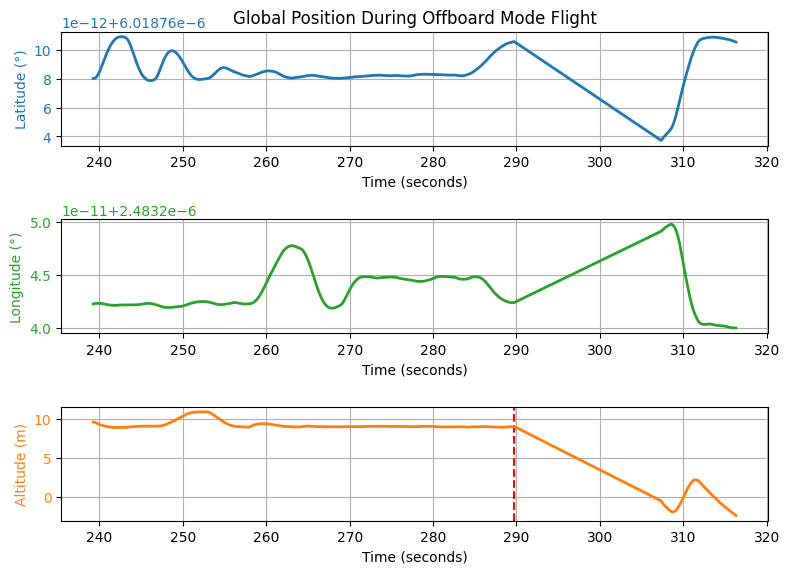

In [64]:
import matplotlib.pyplot as plt

# Initialize lists for global position data
timestamps = []
latitudes = []
longitudes = []
altitudes = []

# Extract global position data from the ulog
for msg in ulog.data_list:
    if msg.name == "vehicle_global_position":
        ts = msg.data["timestamp"] / 1e6  # Convert timestamp to seconds
        lat = msg.data["lat"] / 1e7  # Latitude in degrees
        lon = msg.data["lon"] / 1e7  # Longitude in degrees
        alt = msg.data["alt"]  # Altitude in meters
        
        for idx, _ in enumerate(ts):
            timestamps.append(ts[idx])
            latitudes.append(lat[idx])
            longitudes.append(lon[idx])
            altitudes.append(alt[idx])

# Filter the data for the offboard mode period (between start_time and end_time)
filtered_timestamps = [ts for ts in timestamps if start_time <= ts <= (end_time + 30)]
filtered_latitudes = [latitudes[i] for i in range(len(timestamps)) if timestamps[i] in filtered_timestamps]
filtered_longitudes = [longitudes[i] for i in range(len(timestamps)) if timestamps[i] in filtered_timestamps]
filtered_altitudes = [altitudes[i] for i in range(len(timestamps)) if timestamps[i] in filtered_timestamps]

# Plot the global position data (latitude, longitude, and altitude) over time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

# Plot Latitude vs Time
ax1.plot(filtered_timestamps, filtered_latitudes, label="Latitude", color='tab:blue', linewidth=2)
ax1.set_ylabel("Latitude (°)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.grid(True)
ax1.set_title("Global Position During Offboard Mode Flight")

# Plot Longitude vs Time
ax2.plot(filtered_timestamps, filtered_longitudes, label="Longitude", color='tab:green', linewidth=2)
ax2.set_ylabel("Longitude (°)", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_xlabel("Time (seconds)")
plt.axvline(x=end_time, color='r', linestyle='--', label="Offboard Lost")
ax2.grid(True)

# Plot Altitude vs Time
ax3.plot(filtered_timestamps, filtered_altitudes, label="Altitude", color='tab:orange', linewidth=2)
ax3.set_ylabel("Altitude (m)", color='tab:orange')
ax3.tick_params(axis='y', labelcolor='tab:orange')
ax3.set_xlabel("Time (seconds)")
ax3.grid(True)

# Show the plots
plt.tight_layout()
plt.show()



In [ ]:
Nothing weird there, maybe we can plot the setpoints?

758


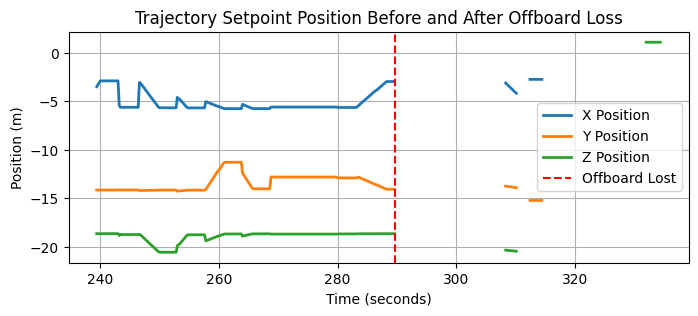

In [74]:
import matplotlib.pyplot as plt
# Initialize lists for trajectory setpoint position data
timestamps = []
x_positions = []
y_positions = []
z_positions = []

# Extract trajectory setpoint position data from ulog
for msg in ulog.data_list:
    if msg.name == "trajectory_setpoint":
        ts = msg.data["timestamp"] / 1e6  # Convert to seconds
        print(len(ts))

        # Only append data if timestamp is within the offboard loss period
        for idx, _ in enumerate(ts):
            if start_time <= ts[idx] <= end_time + 50.0:
                timestamps.append(ts[idx])
                x_positions.append(msg.data["position[0]"][idx])
                y_positions.append(msg.data["position[1]"][idx])
                z_positions.append(msg.data["position[2]"][idx])

# Plot the position data
plt.figure(figsize=(8, 3))
plt.plot(timestamps, x_positions, label="X Position", linewidth=2)
plt.plot(timestamps, y_positions, label="Y Position", linewidth=2)
plt.plot(timestamps, z_positions, label="Z Position", linewidth=2)
plt.axvline(x=end_time, color='r', linestyle='--', label="Offboard Lost")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Trajectory Setpoint Position Before and After Offboard Loss")
plt.grid(True)
plt.show()
